In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

from models import DQN, DuelingDQN

Test the model through inference

In [ ]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=0, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
n_observations = spec.observation_specs[0].shape[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DuelingDQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load('models/10k_episodes/dddqn/policy_net.pth'))
for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    while True:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()

Data visualization

In [5]:
dddrewards = pd.read_csv('models/10k_episodes/dddqn/rewards.csv')
dqnrewards = pd.read_csv('models/10k_episodes/dqn/rewards.csv')


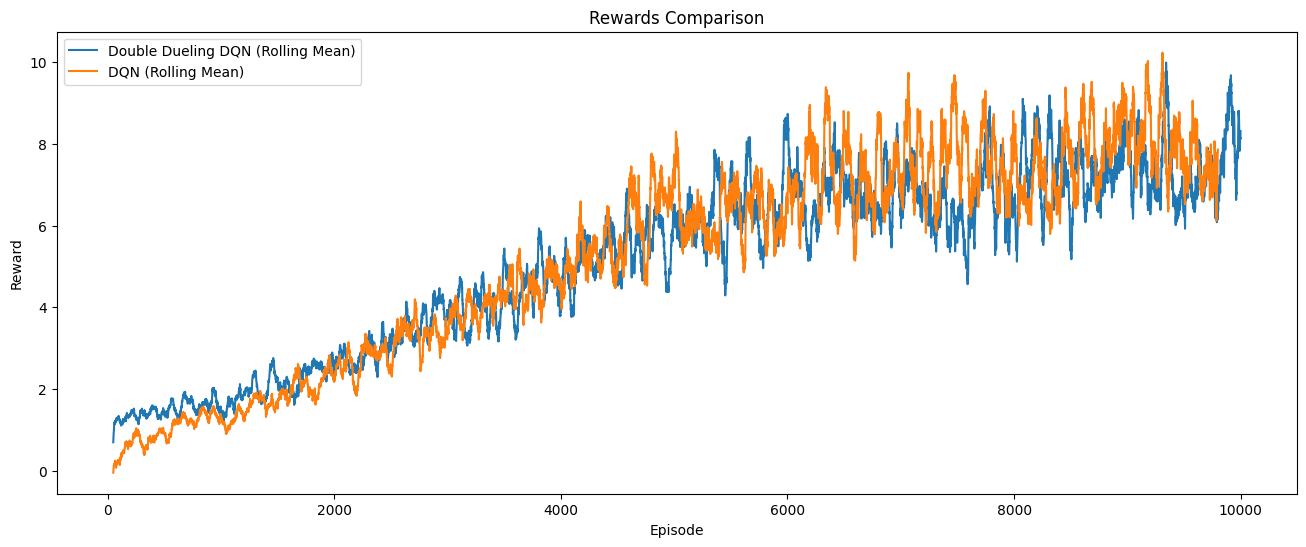

In [19]:
window_size = 50

fig, ax = plt.subplots(figsize=(16, 6))

dddrewards['reward'].rolling(window_size).mean().plot(title='Rewards Comparison', ax=ax, label='Double Dueling DQN (Rolling Mean)')
dqnrewards['reward'].rolling(window_size).mean().plot(ax=ax, label='DQN (Rolling Mean)')

plt.xlabel('Episode')
plt.ylabel('Reward')
ax.legend()

plt.show()